In [31]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE, r2_score as R2
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import BaseCrossValidator

from sklearn.base import BaseEstimator
from typing import Union, Tuple
from xgboost import XGBRegressor
from pprint import pprint
from datetime import datetime
from joblib import dump
import math
from sklearn.model_selection import TimeSeriesSplit #si bien no son series de tiempo nuestros datos si presentan un problema con la similitud del train y test
import mlflow
from mlflow.tracking import MlflowClient


In [33]:
processed_folder = Path.cwd().parent / 'data' / 'processed'
model_folder = Path.cwd().parent / 'models'
plt.style.use('ggplot')

In [34]:
df = pd.read_parquet(processed_folder / 'df_model_tidy.parquet')
df.head()

,date,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
0,2022-11-15 00:07:50,75.761029,39281.348296,65.653747,22.932414,64.260113,36.574719,71.583049,94.815049,54.50695,7.101110,65.598165,9.183127,87.199926
1,2022-11-15 00:08:00,75.761029,39850.320731,65.691489,22.932414,64.260113,36.555098,71.579590,94.815049,54.50695,7.191338,65.798205,9.180693,87.402467
2,2022-11-15 00:08:10,75.761029,39761.319456,65.783858,21.329909,64.260113,36.535478,71.585002,94.815049,54.50695,7.281566,65.998244,9.178803,87.492231
3,2022-11-15 00:08:20,75.761029,39761.319456,65.906084,21.329909,64.260113,36.515857,71.598714,94.815049,54.50695,7.371795,66.198283,9.178803,87.492231
4,2022-11-15 00:08:30,75.761029,39665.960948,65.986245,22.538648,64.260113,36.583533,71.615886,94.815049,54.50695,7.462023,66.398322,9.174560,87.564041


# Pirmer intento

In [35]:
#separacion en train y test
X = df.iloc[:, :-1].drop(columns = 'date')
y = df.presion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Busqueda de parametros y entrenamiento

In [36]:
def search_params(
        estimator: XGBRegressor,
        params,
        X: np.ndarray, 
        y: np.ndarray, 
        random: bool = False, 
        n_iter: int = 100,
    ) -> Tuple[XGBRegressor, dict]:

    with mlflow.start_run():
        for key, value in params.items():
            mlflow.log_param(key, value)

        if random:
            search = RandomizedSearchCV(estimator, params, cv=5, n_jobs=-1, 
                                        scoring='neg_mean_squared_error', verbose=1, n_iter=n_iter)
        else:
            search = GridSearchCV(estimator, params, cv=5, n_jobs=-1, 
                                  scoring='neg_mean_squared_error', verbose=1)

        search.fit(X, y)

        mlflow.log_metric("neg_mean_squared_error", -search.best_score_)

        best_params = search.best_params_
        best_model = search.best_estimator_
        
        mlflow.sklearn.log_model(best_model, "xgbboost_best")
        
        mlflow.end_run()
        
        return best_model, best_params

In [37]:
# Definir los hiperparámetros para XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.3, 0.5, 0.7],
    'reg_lambda':[1, 10, 100],
    'colsample_bytree': [0.5, 0.7]
}

# Llamar a la función con XGBRegressor y los parámetros definidos
xgbModel = XGBRegressor()

best_model, best_params = search_params(xgbModel, 
                                        xgb_params, 
                                        X_train, 
                                        y_train, 
                                        random=False)

# Imprimir el mejor modelo y los mejores parámetros
print(f"Mejor modelo: {best_model}")
print(f"Mejores parámetros: {best_params}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/home/misael/venvs/aprendisaje_automatico/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor modelo: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Mejores parámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1, 'subsample': 0.7}


## Evaluación modelo

In [15]:
#predicciones para test y para train
y_test_hat = best_model.predict(X_test)
y_train_hat = best_model.predict(X_train)

<Axes: title={'center': 'test data'}, ylabel='presion'>

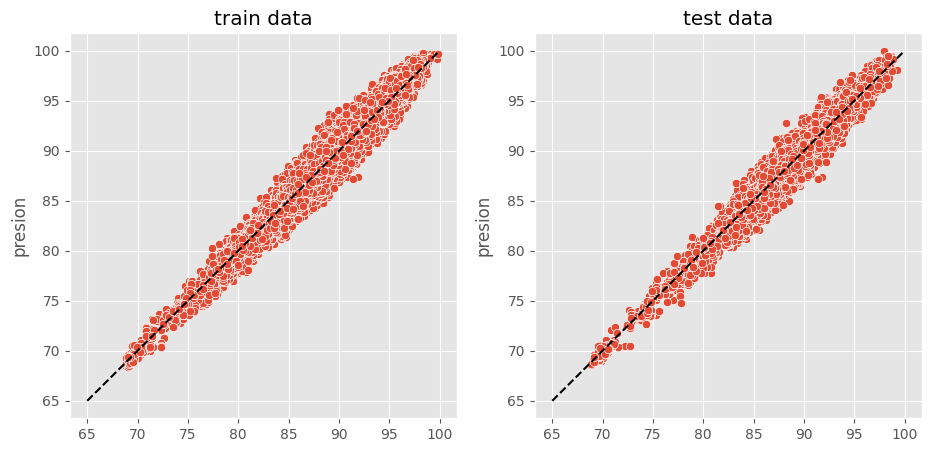

In [16]:
#vizualizacion variable predicha vs variable real
fig, axs = plt.subplots(1, 2, figsize = (11, 5))

axs[0].set_title('train data')
sns.scatterplot(x = y_train_hat, 
                y = y_train,
                ax = axs[0])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[0])

axs[1].set_title('test data')
sns.scatterplot(x = y_test_hat, 
                y = y_test,
                ax = axs[1])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[1])

In [17]:
mae_test = MAE(y_test, y_test_hat)
mae_train = MAE(y_train, y_train_hat)

print(f"error medio absoluto en train {mae_train:.2f}")
print(f"error medio absoluto en test {mae_test:.2f}")

error medio absoluto en train 0.58
error medio absoluto en test 0.60


## Visto desde la serie de tiempo

In [19]:
df['presion_hat'] = np.nan
df.loc[X_train.index, 'presion_hat'] = y_train_hat
df.loc[X_test.index, 'presion_hat'] = y_test_hat

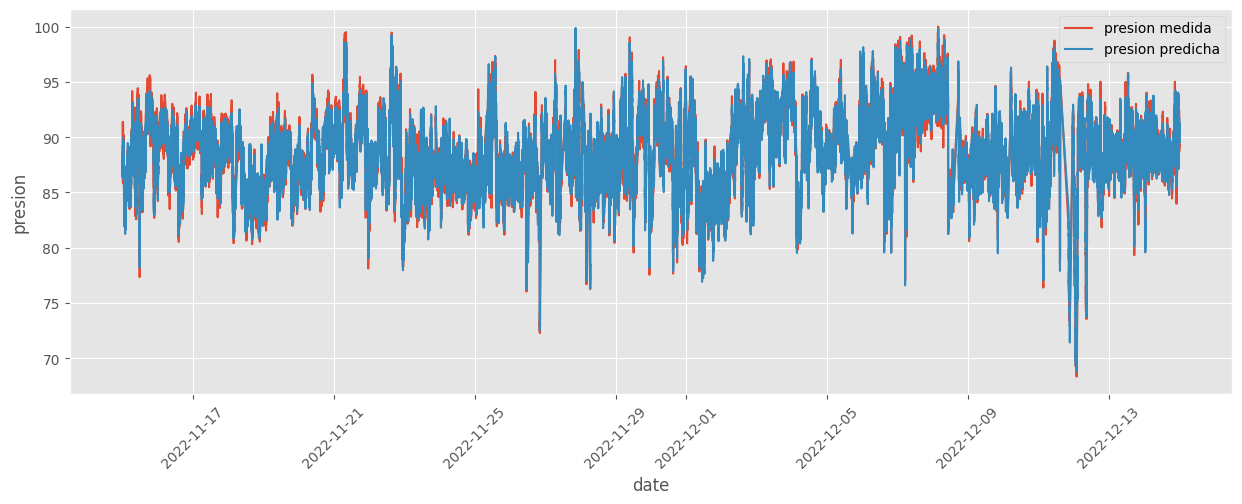

In [20]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(x = 'date',
            y = 'presion',
             data = df,
            label = 'presion medida')
sns.lineplot(x = 'date',
              y = 'presion_hat',
             data = df,
            label = 'presion predicha')
ax.tick_params(axis='x', rotation=45)

## Feature importance

In [20]:
feature_importances = best_model.named_steps['regressor'].feature_importances_
feature_names = X_train.columns

Text(0.5, 1.0, 'Feature Importance of XGBoost Model')

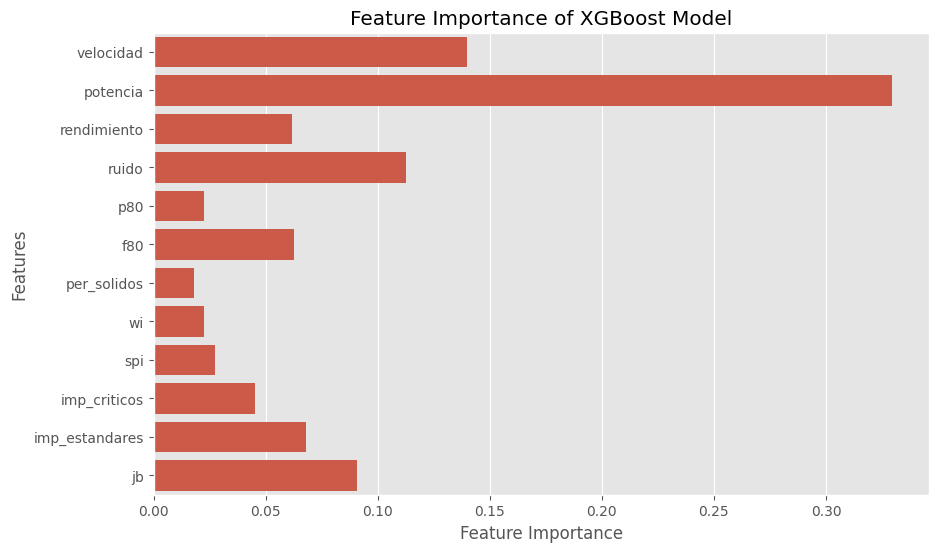

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, ax=ax)


ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance of XGBoost Model')

# Segundo

Para evidtar overfiting en test y train por similutud extrema en datos de train y test, se reservan datos a partir del 10 de diciembre para asegurar que el modelo generaliza a condiciones no vistas.

In [103]:
df.columns

Index(['velocidad', 'potencia', 'ruido', 'rendimiento', 'f80', 'per_solidos',
       'date'],
      dtype='object')

In [57]:
df.columns

#usamos menos variables para evitar sobreajuste
vars_to_use = ['velocidad', 'potencia', 'ruido', 'rendimiento', 'f80', 'per_solidos']

In [58]:
#se hace separacion usual con datos antes del 10
doncition_date = df.date < datetime(2022, 12, 10)
X = df[doncition_date][vars_to_use]
y = df[doncition_date].presion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


#se guardan 5 dias como un test adicional
X_new = df[~doncition_date][vars_to_use]
y_new = df[~doncition_date].presion

## Busqueda de parametros y entrenamiento

Para generalizar mejor a datos no vistos de otras fechas, implementaremos cross-validation dejando huecos de datos intermedios. Esto implica dividir los datos en segmentos, omitiendo períodos específicos (por ejemplo, los primeros 5 días, del 5 al 10, del 15 al 20, etc.) para evaluar la capacidad del modelo para generalizar en situaciones o modos de trabajo no vistos.

In [59]:
class CustomCrossValidator(BaseCrossValidator):
    """
    Generador de cross validation que deja intervalos intermedios como validacion.

    Parameters:
    - n_splits : int, default=5
        Number of splits (folds).
    """

    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        """
            Separa a datos en base a ventaneos
        """
        n_samples = len(X)
        n_test = math.floor(n_samples / self.n_splits)

        for i in range(self.n_splits):
            start_test = i * n_test
            end_test = (i + 1) * n_test

            test_indices = range(start_test, end_test)
            train_indices = set(range(n_samples)) - set(test_indices)

            yield list(train_indices), list(test_indices)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [60]:

# definimos la función que toma datos y devuelve los mejores parámetros

def search_params(
        estimator: BaseEstimator,
        params: dict,
        X: np.ndarray, 
        y: np.ndarray, 
        # window_size: int,
        # gap_size: int,
        name,
        random: bool = False, 
        n_iter: int = 100,
        
    ) -> Tuple[XGBRegressor, dict]:
    # Definir los parámetros para GridSearchCV

    print(f"Los parámetros para probar en nuestras pipelines son:")
    pprint(params)

    # Creamos un pipeline con parámetros por defecto (serán sustituidos)
    with mlflow.start_run():
        for key, value in params.items():
            mlflow.log_param(key, value)
    
        cvC = CustomCrossValidator(n_splits=5) #dejar aprox 5 días
    
        if random:
            search = RandomizedSearchCV(estimator, params, cv=cvC, n_jobs=-1, 
                                        scoring='neg_mean_squared_error', verbose=1, n_iter=n_iter)
        else:
            search = GridSearchCV(estimator, params, cv=cvC, n_jobs=-1, 
                                  scoring='neg_mean_squared_error', verbose=1)
    
        search.fit(X, y)
    
        # Obtener los mejores hiperparámetros y el mejor modelo
        best_params = search.best_params_
        best_model = search.best_estimator_
    
        print(f"Los mejores parámetros de la busqueda: {best_params}")
        print(f"El mejor modelo de la busqueda: {best_model}")
        
        mlflow.log_metric("neg_mean_squared_error", -search.best_score_)
        
        mlflow.sklearn.log_model(best_model, name)
        
        mlflow.end_run()

    return best_model, best_params

In [61]:
# Definir los hiperparámetros para XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.3, 0.6],
    'reg_lambda':[10, 50, 100],
    'colsample_bytree': [0.5, 0.7]
}

# Llamar a la función con XGBRegressor y los parámetros definidos
model = XGBRegressor()
best_model, best_params = search_params(model, 
                                        xgb_params, 
                                        X_train, 
                                        y_train,
                                        'xgbboost_best_2',
                                        random=False)

# Imprimir el mejor modelo y los mejores parámetros
print(f"Mejor modelo: {best_model}")
print(f"Mejores parámetros: {best_params}")

Los parámetros para probar en nuestras pipelines son:
{'colsample_bytree': [0.5, 0.7],
 'learning_rate': [0.01, 0.05, 0.1],
 'max_depth': [3, 4, 5],
 'n_estimators': [50, 100, 200],
 'reg_lambda': [10, 50, 100],
 'subsample': [0.3, 0.6]}
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Los mejores parámetros de la busqueda: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 10, 'subsample': 0.6}
El mejor modelo de la busqueda: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=Non

## Evaluación modelo

error medio absoluto en train 0.58
error medio absoluto en new 2.28


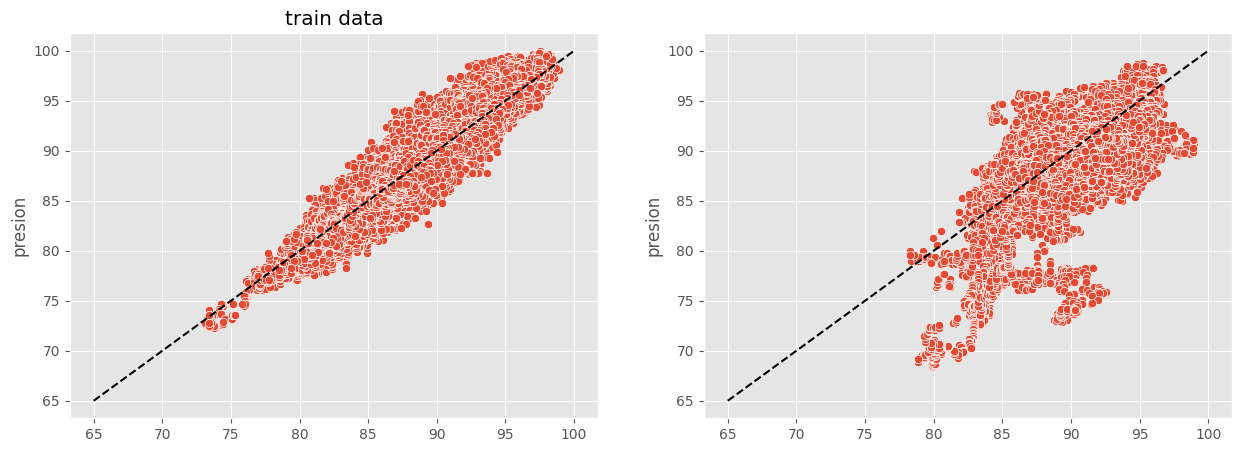

In [62]:
#predicciones para test y para train
y_hat = best_model.predict(X)
# y_train_hat = best_model.predict(X_train)
y_new_hat = best_model.predict(X_new)

#vizualizacion variable predicha vs variable real
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].set_title('train data')
sns.scatterplot(x = y_hat, 
                y = y,
                ax = axs[0])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[0])


sns.scatterplot(x = y_new_hat, 
                y = y_new,
                ax = axs[1])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[1])

mae_test = MAE(y, y_hat)
# mae_train = MAE(y_train, y_train_hat)
mae_new = MAE(y_new, y_new_hat)

print(f"error medio absoluto en train {mae_train:.2f}")
# print(f"error medio absoluto en test {mae_test:.2f}")
print(f"error medio absoluto en new {mae_new:.2f}")

In [63]:
#predicciones para test y para train
y_test_hat = best_model.predict(X_test)
y_train_hat = best_model.predict(X_train)
y_new_hat = best_model.predict(X_new)

<Axes: ylabel='presion'>

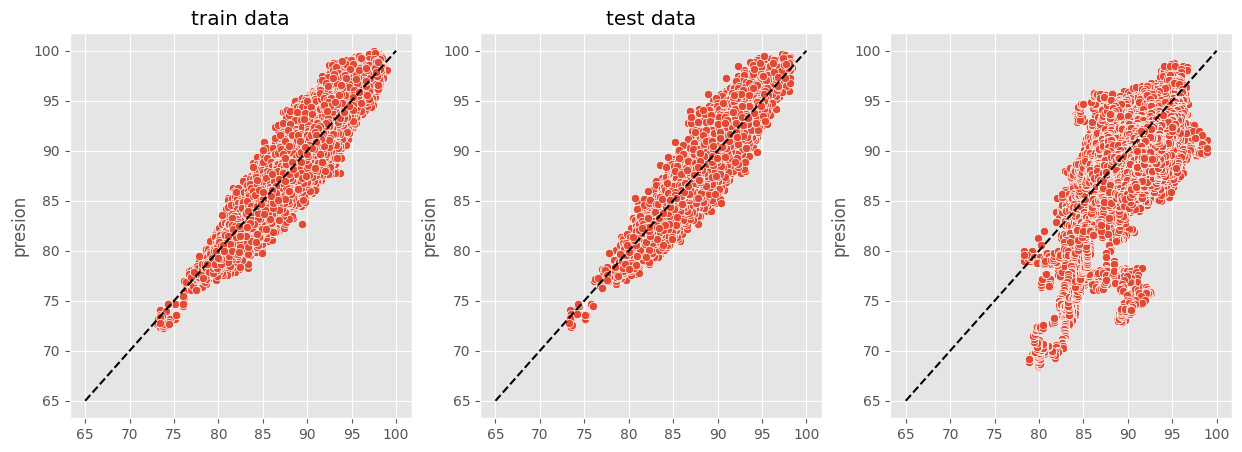

In [64]:
#vizualizacion variable predicha vs variable real
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

axs[0].set_title('train data')
sns.scatterplot(x = y_train_hat, 
                y = y_train,
                ax = axs[0])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[0])

axs[1].set_title('test data')
sns.scatterplot(x = y_test_hat, 
                y = y_test,
                ax = axs[1])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[1])

sns.scatterplot(x = y_new_hat, 
                y = y_new,
                ax = axs[2])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[2])

In [65]:
mae_test = MAE(y_test, y_test_hat)
mae_train = MAE(y_train, y_train_hat)
mae_new = MAE(y_new, y_new_hat)

print(f"error medio absoluto en train {mae_train:.2f}")
print(f"error medio absoluto en test {mae_test:.2f}")
print(f"error medio absoluto en new {mae_new:.2f}")

error medio absoluto en train 0.92
error medio absoluto en test 0.94
error medio absoluto en new 2.28


In [10]:
df['presion_hat'] = np.nan

In [11]:
X_train.index

Index([204020, 229382,  19325, 243547, 236718, 114238, 168820, 145647, 104839,
        75619,
       ...
        53358,  64768, 197548, 166122, 240127,  10891,  71865,  67122, 203040,
       187840],
      dtype='int64', length=198938)

In [12]:
df.loc[X_train.index].shape

(198938, 15)

In [68]:
df.loc[X_train.index, 'presion_hat'] = y_train_hat
df.loc[X_test.index, 'presion_hat'] = y_test_hat
df.loc[X_new.index, 'presion_hat'] = y_new_hat

## Visto desde la serie de tiempo

Text(0.5, 1.0, 'datos antes del 10 de diciembre')

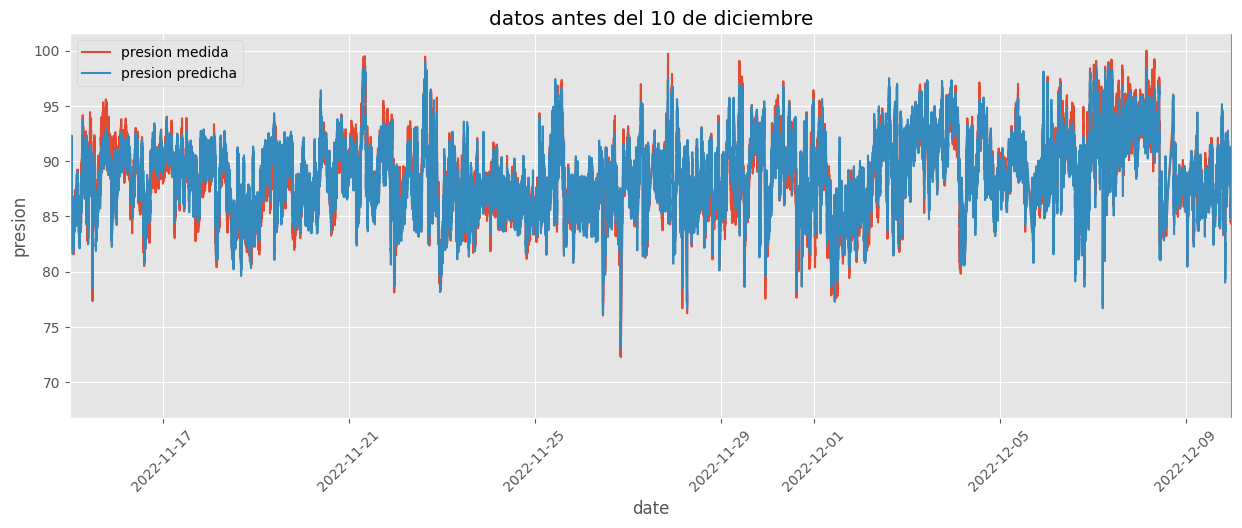

In [84]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(x = 'date',
            y = 'presion',
             data = df,
            label = 'presion medida')
sns.lineplot(x = 'date',
              y = 'presion_hat',
             data = df,
            label = 'presion predicha')
ax.tick_params(axis='x', rotation=45)

ax.set_xlim(datetime(2022, 11, 15), datetime(2022, 12, 10))
ax.axvline(datetime(2022,12, 10))
ax.set_title('datos antes del 10 de diciembre')

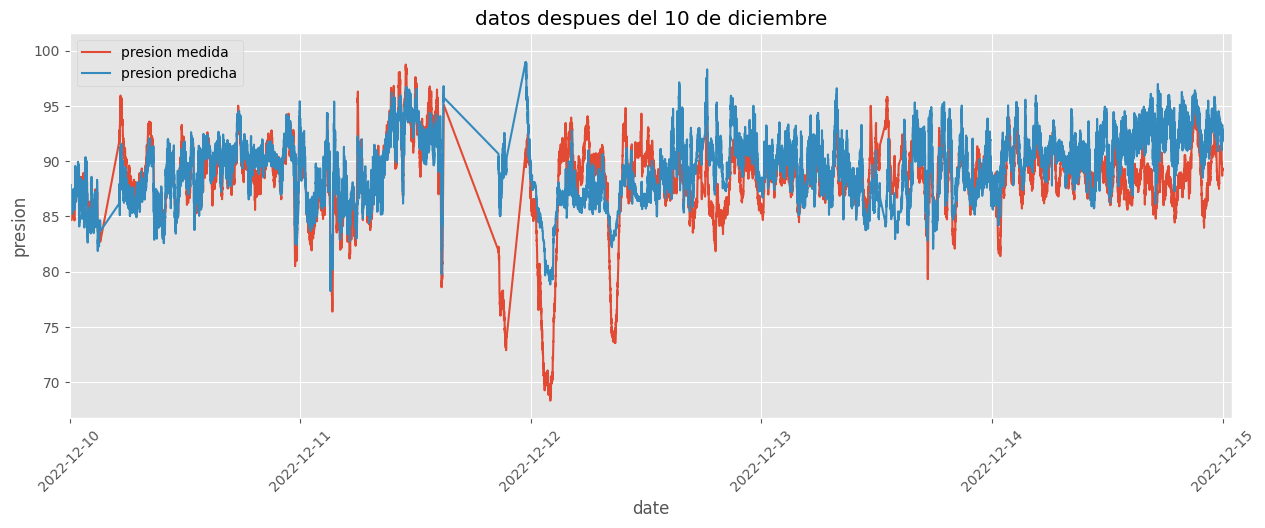

In [82]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(x = 'date',
            y = 'presion',
             data = df,
            label = 'presion medida')
sns.lineplot(x = 'date',
              y = 'presion_hat',
             data = df,
            label = 'presion predicha')
ax.tick_params(axis='x', rotation=45)

ax.set_title('datos despues del 10 de diciembre')
ax.set_xlim(datetime(2022, 12, 10), datetime(2022, 12, 15, 1))
ax.axvline(datetime(2022,12, 10))

## Feature importance

In [79]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

Text(0.5, 1.0, 'Feature Importance of XGBoost Model')

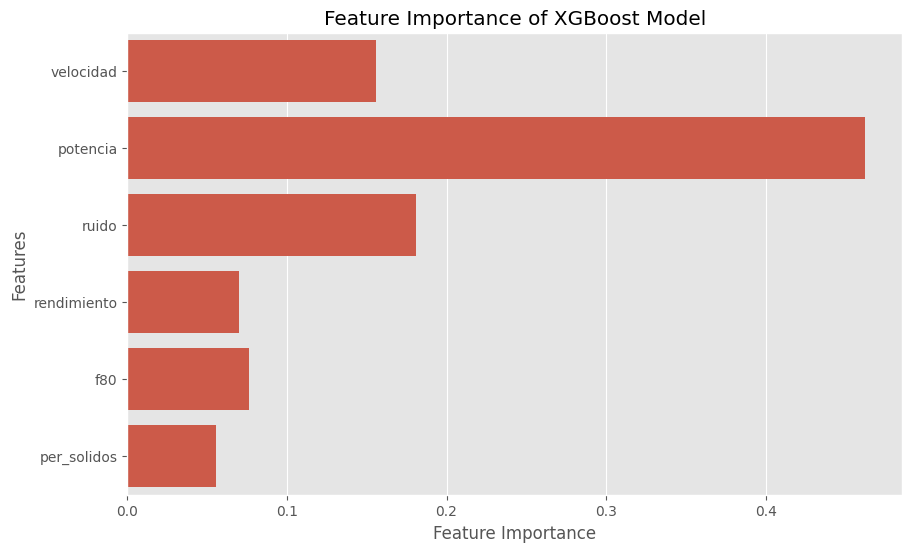

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, ax=ax)


ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance of XGBoost Model')

## Concluso

La variable jb tiene un efecto muy significativo en la presión, pero este efecto no está siendo captado por el modelo. Esto podría deberse a que el nivel de bola, basado en un láser que cuenta el número de bolas, tiene un margen de error considerablemente alto. Si se contara con un jb con desviacion de a lo mas 3.125 (en la escala actual) se podrian obtener mejores resultados con xgboost.